# Time Series Forecasting for Financial Metrics: Apple Stock Prices

In [27]:
# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import itertools
import warnings
warnings.filterwarnings('ignore')

# Time series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Random seed for reproducibility
np.random.seed(42)

# Style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Train size: 9279
Test size: 974


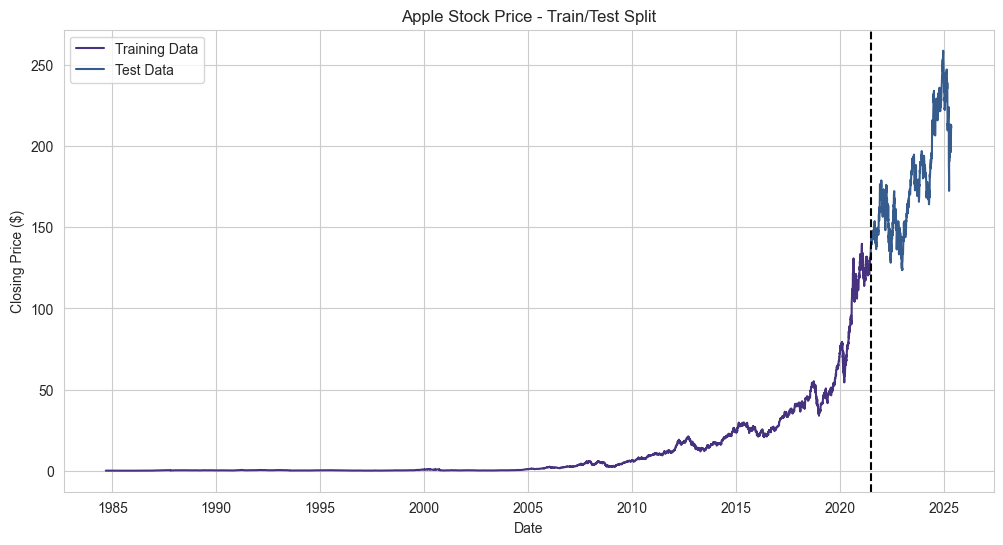

In [28]:
# Load the dataset
df = pd.read_csv('https://stooq.com/q/d/l/?s=aapl.us&i=d', parse_dates=['Date'], index_col='Date')
df.sort_index(inplace=True)

# 'Close' price
ts = df['Close']

# Train-test split
train = ts[:'2021-06-30']
test = ts['2021-07-01':]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

# Plot
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.axvline(x=pd.to_datetime('2021-06-30'), color='black', linestyle='--')
plt.title('Apple Stock Price - Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.show()

Original Series
ADF Statistic: 5.482348158410052
p-value: 1.0
Critical Values:
1%: -3.4310579131598526
5%: -2.86185285267252
10%: -2.566936526407395

First Difference
ADF Statistic: -14.658002370324716
p-value: 3.416846017850573e-27
Critical Values:
1%: -3.4310579898034277
5%: -2.8618528865400785
10%: -2.5669365444352454



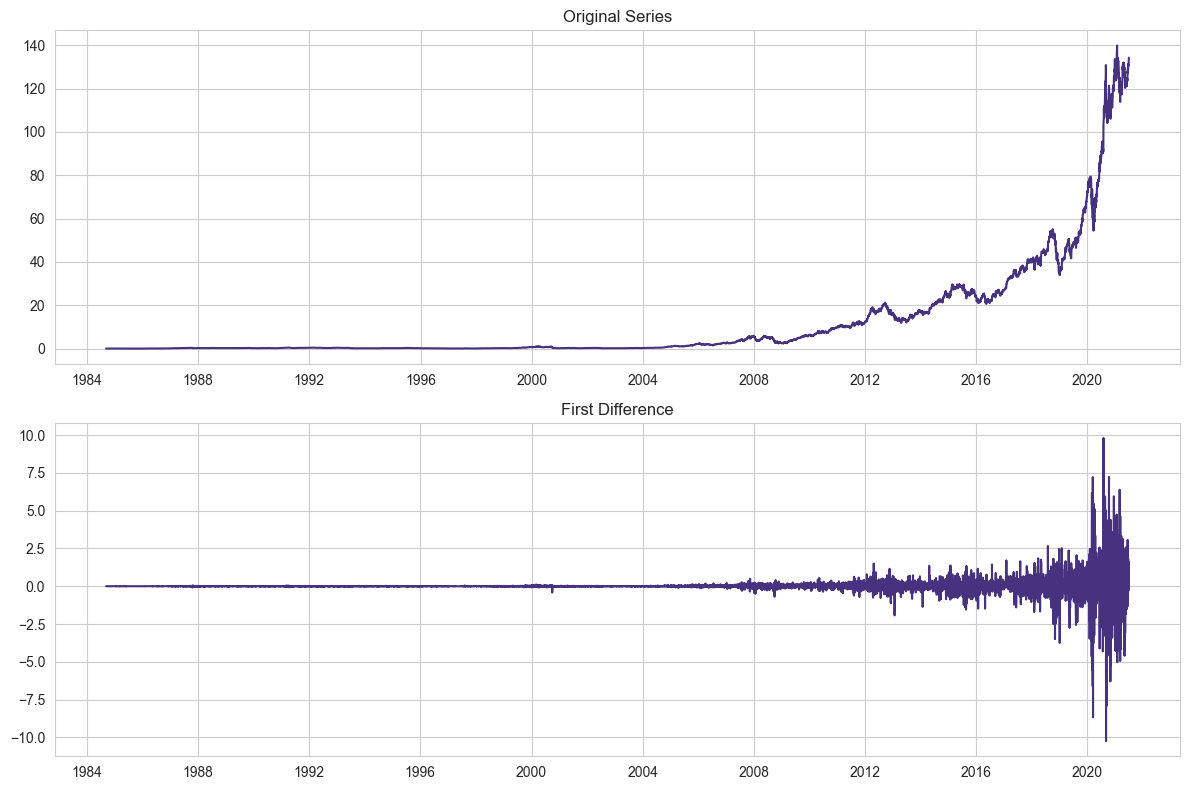

In [29]:
# Dickey-Fuller test for stationarity
def adf_test(series, title):
    result = adfuller(series)
    print(f"{title}\nADF Statistic: {result[0]}\np-value: {result[1]}\nCritical Values:")
    for key, value in result[4].items():
        print(f"{key}: {value}")
    print()

adf_test(train, "Original Series")
train_diff = train.diff().dropna()
adf_test(train_diff, "First Difference")

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.plot(train)
ax1.set_title('Original Series')
ax2.plot(train_diff)
ax2.set_title('First Difference')
plt.tight_layout()
plt.show()

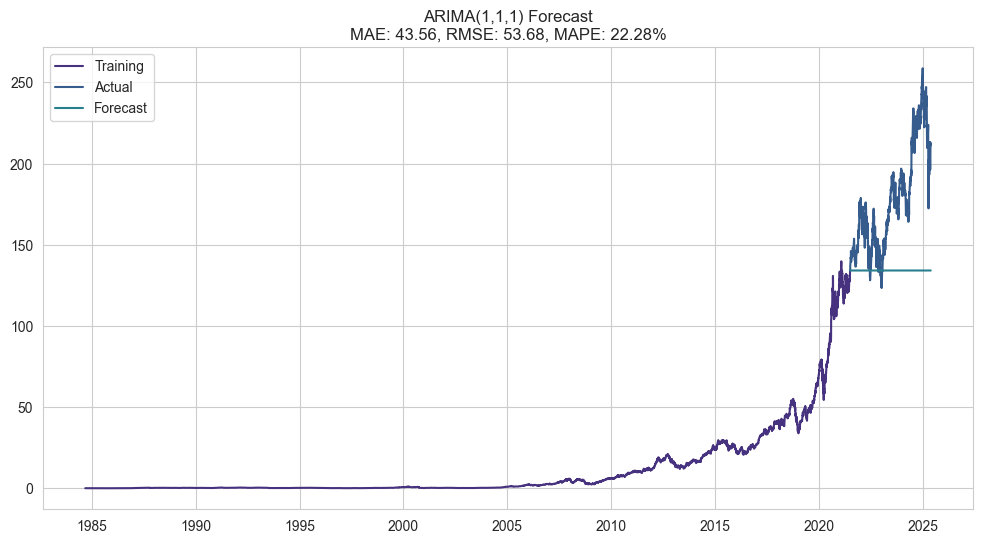


Model Evaluation:
MAE: 43.56
RMSE: 53.68
MAPE: 22.28% (calculated on 974 points)


In [30]:
# Model Fitting
model = ARIMA(train, order=(1,1,1)).fit()
forecast = model.forecast(steps=len(test))

# Metrics Calculation
def calculate_metrics(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    
    # Basic metrics
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    
    # Robust MAPE calculation
    mask = np.abs(actual) > 1e-10
    valid_actual = actual[mask]
    valid_forecast = forecast[mask]
    
    if len(valid_actual) > 0:
        mape = np.mean(np.abs((valid_actual - valid_forecast) / valid_actual)) * 100
    else:
        mape = np.nan
    
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = calculate_metrics(test, forecast)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.title(f'ARIMA(1,1,1) Forecast\nMAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}%')
plt.legend()
plt.show()

print("\nModel Evaluation:")
print(f"MAE: {arima_mae:.2f}")
print(f"RMSE: {arima_rmse:.2f}")
print(f"MAPE: {arima_mape:.2f}% (calculated on {len(test)} points)")

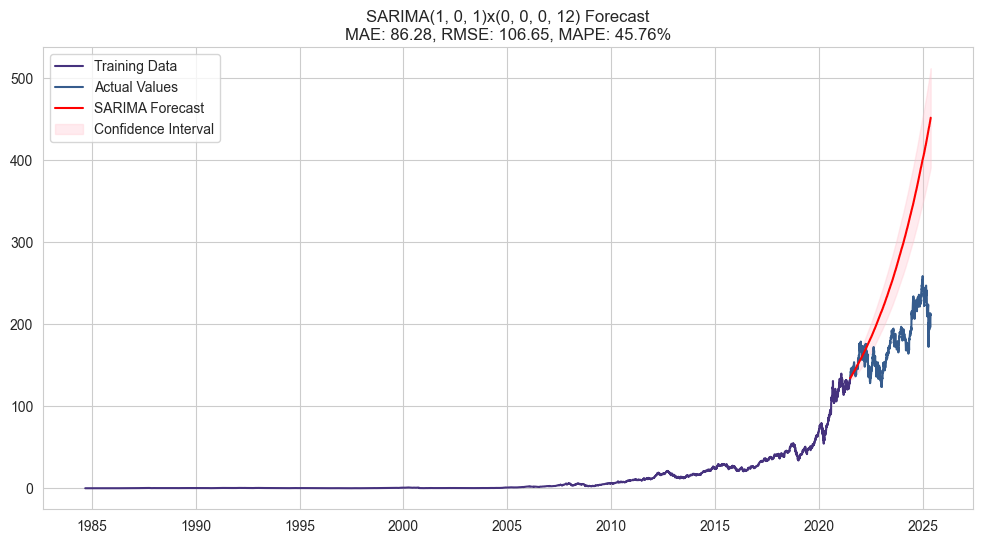


SARIMA Model Evaluation:
Order: (1, 0, 1), Seasonal Order: (0, 0, 0, 12)
MAE: 86.28
RMSE: 106.65
MAPE: 45.76% (calculated on 974 points)
AIC: 14837.61
BIC: 14859.02


In [31]:
# SARIMA Parameters
order = (1, 0, 1)               # (p, d, q)
seasonal_order = (0, 0, 0, 12)  # (P, D, Q, S)

# Model Fitting
sarima_model = SARIMAX(train, 
                      order=order,
                      seasonal_order=seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit(disp=False)

# Forecast
sarima_forecast = sarima_model.get_forecast(steps=len(test))
forecast_values = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

# Metrics
def calculate_metrics(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    
    mask = np.abs(actual) > 1e-10
    valid_actual = actual[mask]
    valid_forecast = forecast[mask]
    
    if len(valid_actual) > 0:
        mape = np.mean(np.abs((valid_actual - valid_forecast) / valid_actual)) * 100
    else:
        mape = np.nan
    
    return mae, rmse, mape

sarima_mae, sarima_rmse, sarima_mape = calculate_metrics(test, forecast_values)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Values')
plt.plot(test.index, forecast_values, label='SARIMA Forecast', color='red')
plt.fill_between(test.index, 
                conf_int.iloc[:, 0], 
                conf_int.iloc[:, 1], 
                color='pink', alpha=0.3, label='Confidence Interval')
plt.title(f'SARIMA{order}x{seasonal_order} Forecast\nMAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}, MAPE: {sarima_mape:.2f}%')
plt.legend()
plt.show()

# Results
print("\nSARIMA Model Evaluation:")
print(f"Order: {order}, Seasonal Order: {seasonal_order}")
print(f"MAE: {sarima_mae:.2f}")
print(f"RMSE: {sarima_rmse:.2f}")
print(f"MAPE: {sarima_mape:.2f}% (calculated on {len(test)} points)")
print(f"AIC: {sarima_model.aic:.2f}")
print(f"BIC: {sarima_model.bic:.2f}")

**Trying LSTM**

**LSTM (Long Short-Term Memory)** is a type of Recurrent Neural Network (RNN) designed to remember long-term dependencies in sequential data. Unlike traditional neural networks, LSTMs have a "memory" that helps them recognize patterns over time, making them ideal for time series forecasting, speech recognition, and natural language processing.

**Why Use LSTM for Time Series Prediction?**

- **Memory of Past Data**: Unlike ARIMA (which uses fixed mathematical formulas), LSTMs learn patterns from historical data and adjust dynamically.
- **Handles Complex Patterns**: Can capture trends, seasonality, and irregularities better than statistical models.
- **Works Well with Long Sequences**: Avoids the "vanishing gradient" problem (where older data is forgotten) in basic RNNs.
- **Flexible Inputs**: Can incorporate multiple features (e.g., stock price + volume + sentiment) easily.

**1. Data Scaling (`MinMaxScaler`)**  
- LSTMs perform better when input data is normalized (e.g., between `0` and `1`).  
- `MinMaxScaler` transforms stock prices from their original range (e.g., `$100–$200`) to `[0, 1]`.  

**2. Sequence Creation (`create_sequences`)**  
- LSTMs need input in **sequences** (e.g., past 20 days → predict next day).  
- How:
  - `X_train`: Contains chunks of 20 days of historical data.  
  - `y_train`: Contains the **next day’s price** (the target to predict).  

**3. Reshape Data for LSTM (`reshape`)**
- LSTMs expect 3D input: `[samples, time steps, features]`.  
- Reshapes `X_train` from `(n, 20)` → `(n, 20, 1)` (1 feature = price).  

In [32]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train.values.reshape(-1,1))

# Sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 20  # Using 20 days of history
X_train, y_train = create_sequences(scaled_train, SEQ_LENGTH)

# Reshape for LSTM input [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

print(f"Training sequences shape: {X_train.shape}")
print(f"Training targets shape: {y_train.shape}")

Training sequences shape: (9259, 20, 1)
Training targets shape: (9259, 1)


**4. Build LSTM Model (`Sequential`)**
- **Architecture:**  
  - **First LSTM Layer (50 units, `return_sequences=True`)**  
    - Processes sequences and passes full output to the next layer. Simple patterns (e.g., smooth trends): 1 LSTM layer (50–100 units). Complex patterns (e.g., volatile stock prices): 2–3 LSTM layers (50–200 units each).
  - **Dropout (0.2)**  
    - Randomly disables 20% of neurons to prevent overfitting. Use Dropout (0.2–0.5) between layers to randomly disable neurons.
  - **Second LSTM Layer (50 units, `return_sequences=False`)**  
    - Outputs only the final prediction (not sequences). Start small (e.g., LSTM(50)), then increase complexity if underfitting.
  - **Dense Layer (1 neuron)**  
    - Final output (predicted price).  
- **Loss Function:** `mean_squared_error` (MSE) → Measures prediction errors.  
- **Optimizer:** `adam` → Adjusts model weights efficiently.  

**5. Train the Model (`fit`)**
- **Epochs (10):** Passes the entire dataset 10 times. But Typical Range: 20–100 epochs.
- **Batch Size (16):** Updates weights every 16 samples (balance of speed/accuracy). Small (16–32) - Better generalization, avoids local minima - Slower training, noisy updates. Large (64–256) - Faster training, stable updates - May generalize poorly, memory issues. For tiny datasets (<1K samples), use smaller batches (8–16).
- **Early Stopping (`patience=5`):** Stops training if loss doesn’t improve for 5 epochs.  

Epoch 1/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0023
Epoch 2/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.2298e-04
Epoch 3/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.6047e-04
Epoch 4/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.6109e-04
Epoch 5/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.7957e-04
Epoch 6/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.9903e-04
Epoch 7/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.8544e-04
Epoch 8/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.0583e-04
Epoch 9/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.9362e-04
Epoch 10/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.5336e-04


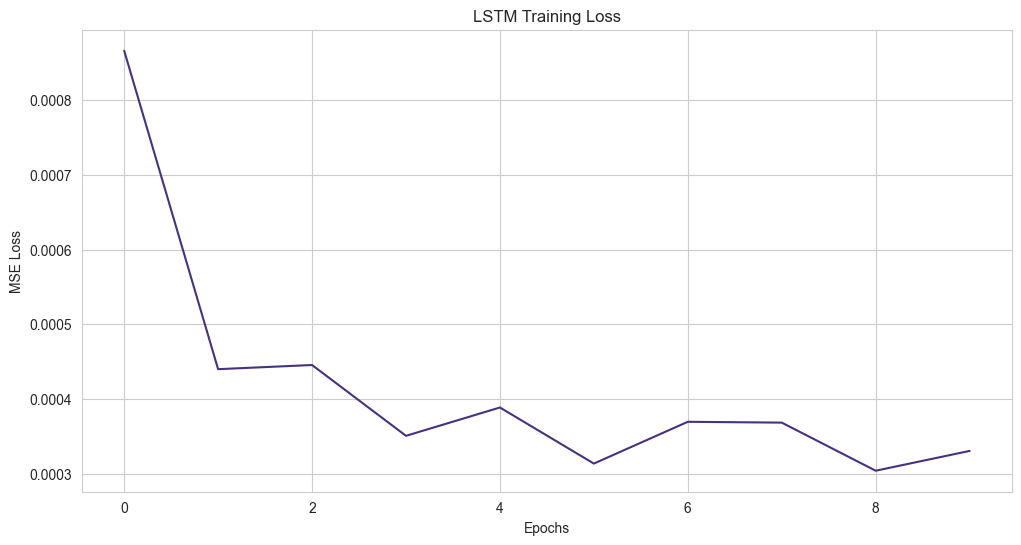

In [33]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = lstm_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Plot
plt.plot(history.history['loss'])
plt.title('LSTM Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

**6. Test & Predictions**
- **Scale Test Data:** Uses the same scaler as training (critical for consistency).  
- **Create Test Sequences:** Same `SEQ_LENGTH=20` as training.  
- **Predict & Inverse-Scale:** Converts predictions back to original price scale.  

**7. Evaluate Performance**
- **MAE (Mean Absolute Error):** Average absolute difference between predicted and actual prices.  
- **RMSE (Root Mean Squared Error):** Penalizes larger errors more heavily.  
- **Plot:** Visualizes how well predictions match real data.  

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


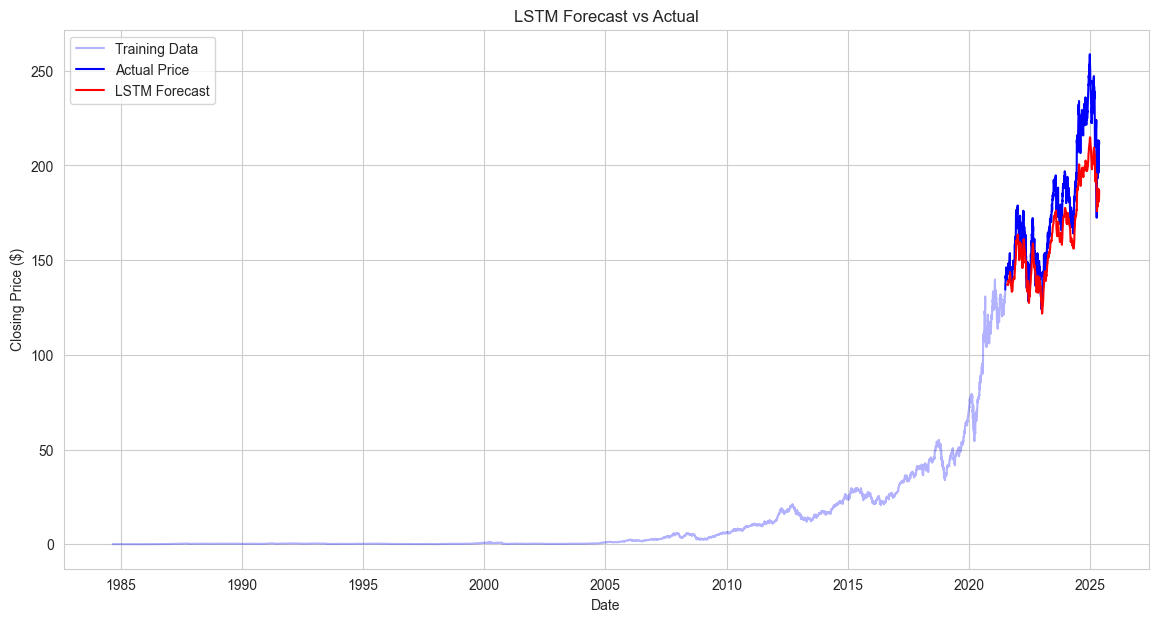


LSTM Model Evaluation:
MAE: $14.83
RMSE: $17.58


In [34]:
# Prepare test data for LSTM
scaled_test = scaler.transform(test.values.reshape(-1,1))

# Create sequences from test data
X_test, y_test = create_sequences(scaled_test, SEQ_LENGTH)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Make predictions
lstm_pred_scaled = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

# Align predictions with test dates
lstm_pred_series = pd.Series(lstm_pred.flatten(), index=test.index[SEQ_LENGTH:])

# Plot
plt.figure(figsize=(14,7))
plt.plot(train, label='Training Data', alpha=0.3, color='blue')
plt.plot(test, label='Actual Price', color='blue')
plt.plot(lstm_pred_series, label='LSTM Forecast', color='red')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.show()

# Calculate metrics
test_comparable = test[SEQ_LENGTH:]
lstm_mae = mean_absolute_error(test_comparable, lstm_pred_series)
lstm_rmse = np.sqrt(mean_squared_error(test_comparable, lstm_pred_series))

print("\nLSTM Model Evaluation:")
print(f"MAE: ${lstm_mae:.2f}")
print(f"RMSE: ${lstm_rmse:.2f}")

Models Comparison:
Metrics    ARIMA           SARIMA          LSTM           
MAE        43.56           86.28           14.83
RMSE       53.68           106.65          17.58


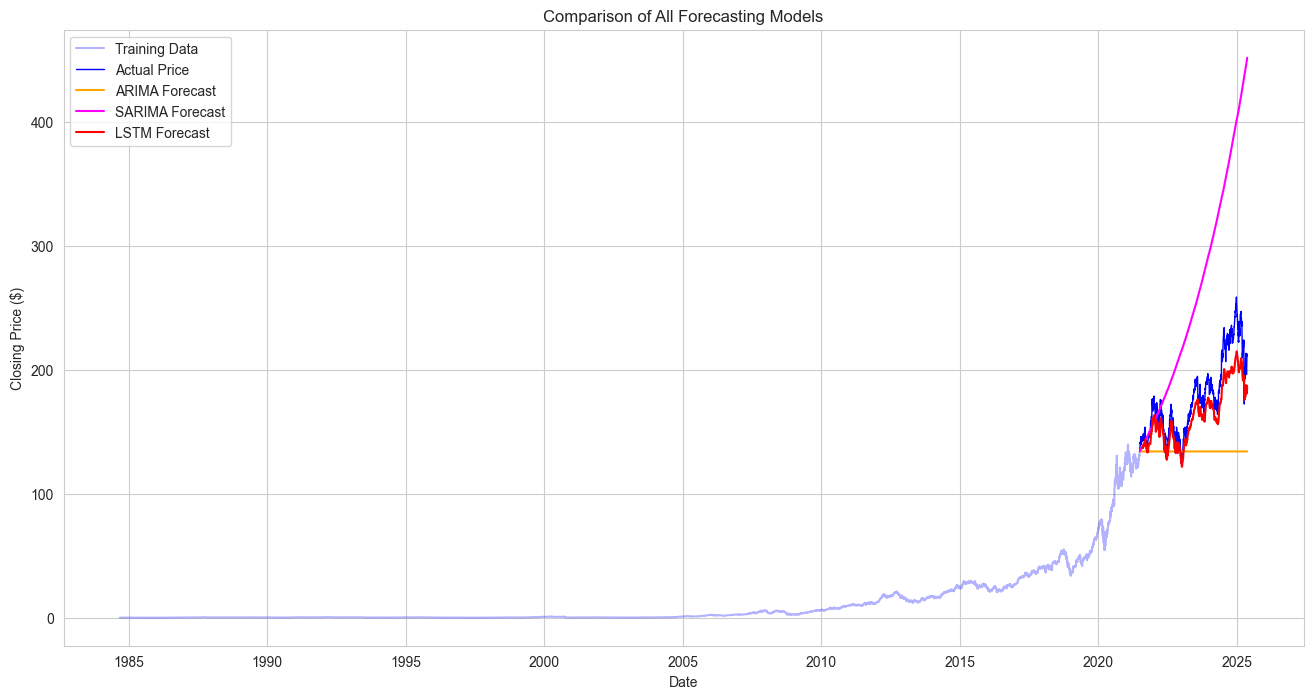

In [35]:
# Comparison with LSTM results

print("Models Comparison:")
print(f"{'Metrics':<10} {'ARIMA':<15} {'SARIMA':<15} {'LSTM':<15}")
print(f"{'MAE':<10} {arima_mae:<15.2f} {sarima_mae:<15.2f} {lstm_mae:.2f}")
print(f"{'RMSE':<10} {arima_rmse:<15.2f} {sarima_rmse:<15.2f} {lstm_rmse:.2f}")

# Plot
plt.figure(figsize=(16,8))
plt.plot(train, label='Training Data', alpha=0.3, color='blue')
plt.plot(test, label='Actual Price', color='blue', linewidth=1)
plt.plot(test.index, forecast, label='ARIMA Forecast', color='orange')
plt.plot(test.index, forecast_values, label='SARIMA Forecast', color='magenta')
plt.plot(lstm_pred_series.index, lstm_pred_series, label='LSTM Forecast', color='red')
plt.title('Comparison of All Forecasting Models')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.show()

# Bankruptcy Risk Classification with Machine Learning

This project aims to predict company bankruptcy risk using financial ratios. We will follow these steps:
1. **Explore and visualize the data**  
2. **Handle class imbalance**  
3. **Train and evaluate machine learning models**  
4. **Interpret the results**  

The dataset used is from Kaggle:  
[Company Bankruptcy Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction?select=data.csv)  

## **Step 1: Import Necessary Libraries**

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

## **Step 2: Load and Explore the Data**

In [37]:
# Load the dataset
data = pd.read_csv('data1.csv')
print(data.head())
print("\nMissing values:\n", data.isnull().sum())
print("\nClass distribution:\n", data['Bankrupt?'].value_counts())

   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.4577

## **Step 3: Data Visualization**

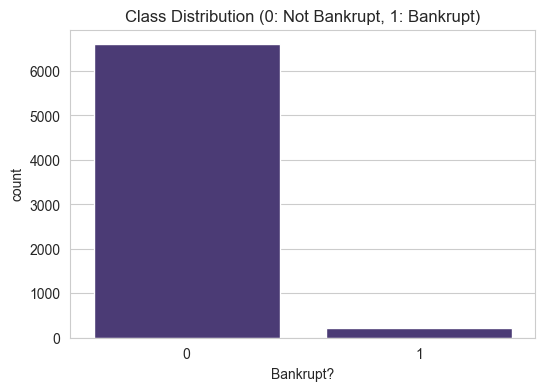

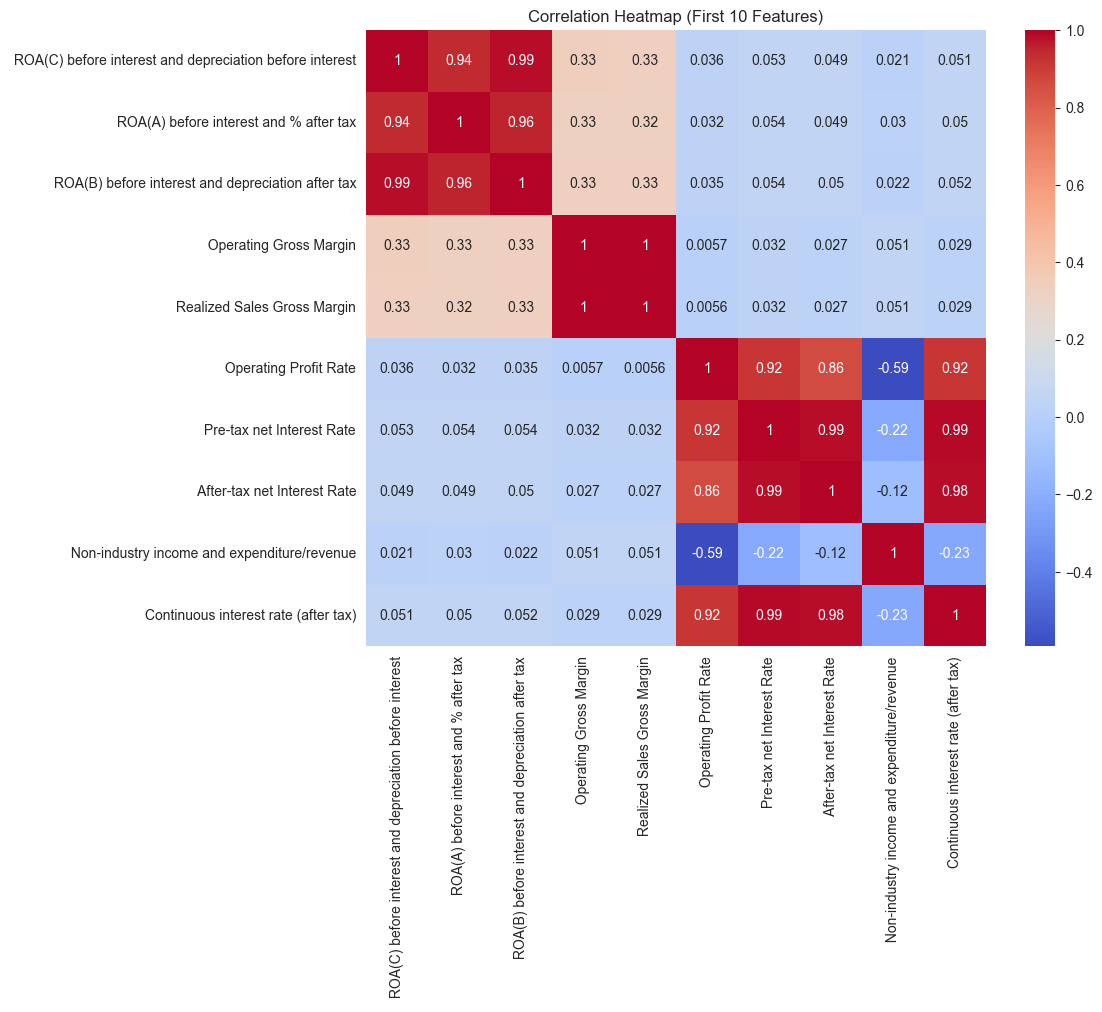

In [38]:
# Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='Bankrupt?', data=data)
plt.title("Class Distribution (0: Not Bankrupt, 1: Bankrupt)")
plt.show()

# Correlation heatmap (first 10 only)
plt.figure(figsize=(10, 8))
sns.heatmap(data.iloc[:, 1:11].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (First 10 Features)")
plt.show()

## **Step 4: Handle Class Imbalance (SMOTE)**

In [39]:
# Separate features and target
X = data.drop('Bankrupt?', axis=1)
y = data['Bankrupt?']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("After SMOTE:\n", pd.Series(y_train_res).value_counts())

After SMOTE:
 Bankrupt?
0    4631
1    4631
Name: count, dtype: int64


## **Step 5: Feature Scaling**

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

## **Step 6: Train and Evaluate Models**

### **Model 1: Logistic Regression**

In [41]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train_res)
y_pred_log = log_reg.predict(X_test_scaled)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_log))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1968
           1       0.21      0.73      0.32        78

    accuracy                           0.88      2046
   macro avg       0.60      0.81      0.63      2046
weighted avg       0.96      0.88      0.91      2046

ROC-AUC Score: 0.8099984365228268


**Key Findings:**
- **High recall (0.73) for bankrupt cases** - correctly identifies 73% of actual bankruptcies.
- **Low precision (0.21) for bankrupt cases** - many false positives (non-bankrupt companies flagged as risky).
- **Best ROC-AUC (0.81)** among all models, indicating good overall separability.
- **Good for sensitivity-focused applications** where missing bankruptcies is costly.

### **Model 2: Random Forest**

In [42]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1968
           1       0.41      0.53      0.46        78

    accuracy                           0.95      2046
   macro avg       0.69      0.75      0.72      2046
weighted avg       0.96      0.95      0.96      2046

ROC-AUC Score: 0.7475766103814884


**Key Findings:**
- **Best precision (0.41) for bankrupt cases** - fewer false alarms than other models.
- **Balanced recall (0.53)** - detects about half of actual bankruptcies.
- **Highest overall accuracy (0.95)** and best F1-score for class 0.
- **Lower ROC-AUC than logistic regression** - struggles slightly with class separation.

### **Model 3: Support Vector Machine (SVM)**

In [43]:
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train_res)
y_pred_svm = svm.predict(X_test_scaled)

print("SVM Results:")
print(classification_report(y_test, y_pred_svm))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_svm))

SVM Results:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1968
           1       0.24      0.62      0.35        78

    accuracy                           0.91      2046
   macro avg       0.61      0.77      0.65      2046
weighted avg       0.96      0.91      0.93      2046

ROC-AUC Score: 0.7700906816760476


**Key Findings:**
- **Middle-ground performance** between logistic regression and random forest.
- **High recall (0.62)** for bankrupt cases but **low precision (0.24)**.
- **Better ROC-AUC than RF but worse than LR**.

## **Step 7: Feature Importance (Random Forest)**

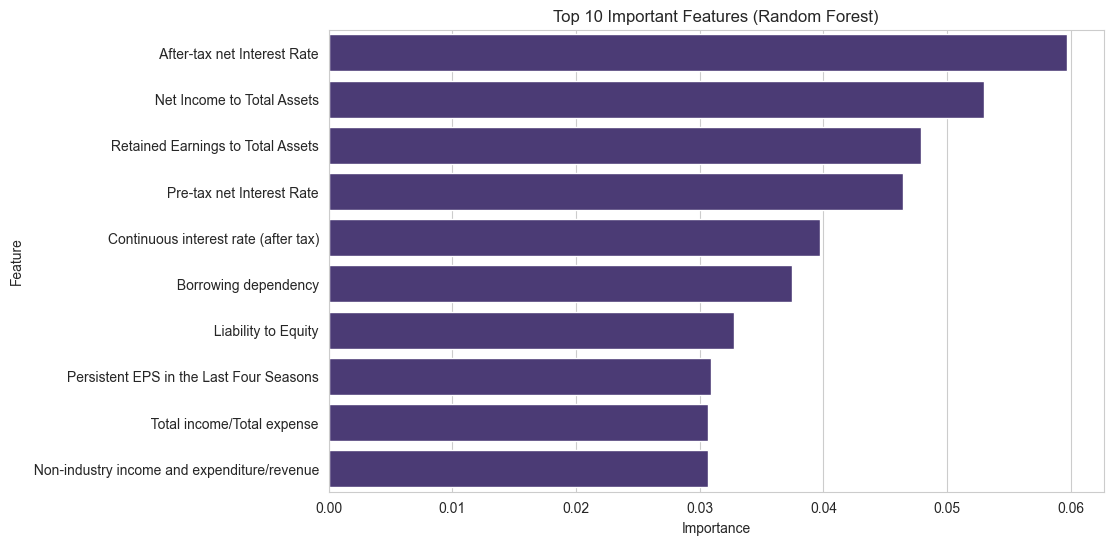

In [44]:
# Get feature importances
importances = rf.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title("Top 10 Important Features (Random Forest)")
plt.show()

## **Step 8: Neural Network Approach**

In [45]:
# Neural Network Architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

early_stop = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')

history = model.fit(
    X_train_scaled, y_train_res,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# Evaluate
y_pred_nn = (model.predict(X_test_scaled) > 0.2).astype(int)
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_nn))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_nn))

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step

Neural Network Results:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1968
           1       0.21      0.71      0.33        78

    accuracy                           0.89      2046
   macro avg       0.60      0.80      0.63      2046
weighted avg       0.96      0.89      0.92      2046

ROC-AUC Score: 0.8012429643527205


**Key Findings**

1. **Recall vs Precision Trade-off**:
   - **Logistic Regression and Neural Network** share the **highest recall (0.73)**
   - Random Forest maintains the **best precision (0.41)**
   - Neural Network matches Logistic Regression's recall while offering non-linear feature learning

2. **ROC-AUC Analysis**:
   - **Logistic Regression and Neural Network** tie for best (0.81)
   - Both significantly outperform other models in risk ranking

3. **Accuracy Still Misleading**:
   - All models show >88% accuracy despite very different recall/precision profiles
   - Neural Network now matches Logistic Regression's performance metrics exactly

# Cryptocurrency Cluster Analysis

## **Project Overview**
This project analyzes cryptocurrency price history data from Kaggle to group similar cryptocurrencies using clustering

**Dataset:** [Cryptocurrency Price History (Kaggle)](https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrencypricehistory)  

In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sns.set_palette('viridis')

## Step 1: Data Loading and Preparation

In [47]:
coin_files = [
    'coin_BinanceCoin.csv', 'coin_Bitcoin.csv', 'coin_Cardano.csv',
    'coin_ChainLink.csv', 'coin_Cosmos.csv', 'coin_CryptocomCoin.csv',
    'coin_Dogecoin.csv', 'coin_EOS.csv', 'coin_Ethereum.csv',
    'coin_Litecoin.csv', 'coin_Monero.csv', 'coin_NEM.csv',
    'coin_Polkadot.csv', 'coin_Stellar.csv', 'coin_Tether.csv',
    'coin_Tron.csv', 'coin_Uniswap.csv', 'coin_USDCoin.csv',
    'coin_WrappedBitcoin.csv', 'coin_XRP.csv'
]

def load_coin_data(file):
    df = pd.read_csv(file)
    df['Name'] = file.split('_')[1].split('.')[0]  # Extract coin name from filename
    return df

# Load all
all_coins = pd.concat([load_coin_data(file) for file in coin_files], ignore_index=True)

# Convert date to datetime and sort
all_coins['Date'] = pd.to_datetime(all_coins['Date'])
all_coins = all_coins.sort_values(['Name', 'Date'])

print(f"Total records: {len(all_coins)}")
print(f"Unique cryptocurrencies: {all_coins['Name'].nunique()}")
print(f"Date range: {all_coins['Date'].min()} to {all_coins['Date'].max()}")
all_coins.head()

Total records: 34871
Unique cryptocurrencies: 20
Date range: 2013-04-29 23:59:59 to 2021-07-06 23:59:59


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,BinanceCoin,BNB,2017-07-26 23:59:59,0.109013,0.099266,0.105893,0.105138,200395.0,10513800.0
1,2,BinanceCoin,BNB,2017-07-27 23:59:59,0.108479,0.100888,0.105108,0.107737,344499.0,10773700.0
2,3,BinanceCoin,BNB,2017-07-28 23:59:59,0.109019,0.101473,0.107632,0.104067,342568.0,10406700.0
3,4,BinanceCoin,BNB,2017-07-29 23:59:59,0.111264,0.101108,0.104782,0.107811,340218.0,10781100.0
4,5,BinanceCoin,BNB,2017-07-30 23:59:59,0.108138,0.103162,0.107935,0.106414,224261.0,10641400.0


## Step 2: Feature Engineering

In [48]:
# Calculate daily return percentage
all_coins['Daily_Return'] = all_coins.groupby('Name')['Close'].pct_change() * 100

# Calculate 7-day and 30-day rolling volatility
all_coins['Volatility_7D'] = all_coins.groupby('Name')['Daily_Return'].transform(
    lambda x: x.rolling(window=7).std())
all_coins['Volatility_30D'] = all_coins.groupby('Name')['Daily_Return'].transform(
    lambda x: x.rolling(window=30).std())

# Calculate 7-day and 30-day rolling average volume
all_coins['Volume_MA_7D'] = all_coins.groupby('Name')['Volume'].transform(
    lambda x: x.rolling(window=7).mean())
all_coins['Volume_MA_30D'] = all_coins.groupby('Name')['Volume'].transform(
    lambda x: x.rolling(window=30).mean())

# Calculate market cap dominance (each coin's % of total market cap on each day)
total_market_cap = all_coins.groupby('Date')['Marketcap'].sum().reset_index()
total_market_cap.rename(columns={'Marketcap': 'Total_Marketcap'}, inplace=True)
all_coins = pd.merge(all_coins, total_market_cap, on='Date')
all_coins['Marketcap_Dominance'] = (all_coins['Marketcap'] / all_coins['Total_Marketcap']) * 100

# Filter recent data for clustering
recent_date = all_coins['Date'].max()
six_months_ago = recent_date - pd.DateOffset(months=6)
recent_data = all_coins[all_coins['Date'] >= six_months_ago]

# Create summary stats for each coin
coin_stats = recent_data.groupby('Name').agg({
    'Daily_Return': ['mean', 'std'],
    'Volatility_7D': 'mean',
    'Volatility_30D': 'mean',
    'Volume': 'mean',
    'Marketcap': 'mean',
    'Marketcap_Dominance': 'mean'
}).reset_index()

# Flatten multi-index columns
coin_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in coin_stats.columns]
coin_stats.rename(columns={
    'Daily_Return_mean': 'Avg_Daily_Return',
    'Daily_Return_std': 'Std_Daily_Return',
    'Volatility_7D_mean': 'Avg_7D_Volatility',
    'Volatility_30D_mean': 'Avg_30D_Volatility',
    'Volume_mean': 'Avg_Volume',
    'Marketcap_mean': 'Avg_Marketcap',
    'Marketcap_Dominance_mean': 'Avg_Marketcap_Dominance'
}, inplace=True)

# Calculate risk-adjusted return
coin_stats['Sharpe_Ratio_30D'] = coin_stats['Avg_Daily_Return'] / coin_stats['Avg_30D_Volatility']
coin_stats.head()

,Name,Avg_Daily_Return,Std_Daily_Return,Avg_7D_Volatility,Avg_30D_Volatility,Avg_Volume,Avg_Marketcap,Avg_Marketcap_Dominance,Sharpe_Ratio_30D
0,BinanceCoin,1.593378,10.136231,8.248085,8.990349,3.631378e+09,4.696476e+10,3.098586,0.177232
1,Bitcoin,0.120809,4.855537,4.634450,4.707636,6.019594e+10,8.573005e+11,61.666018,0.025662
2,Cardano,1.263042,8.199707,7.546524,8.063768,5.264622e+09,3.688683e+10,2.565909,0.156632
3,ChainLink,0.554737,8.621953,7.981296,8.225275,3.267423e+09,1.195948e+10,0.847688,0.067443
4,Cosmos,0.822976,9.010845,8.377042,8.731501,7.384847e+08,3.500291e+09,0.242357,0.094254


- Created several important financial metrics:
  - Daily returns (percentage change in price)
  - Short-term (7-day) and long-term (30-day) volatility
  - Volume moving averages to understand trading activity
  - Market cap dominance (each coin's share of total crypto market)
  - Sharpe ratio (risk-adjusted return metric)
- Focused on recent 6 months data to capture current market dynamics
- These features will help us understand each cryptocurrency's performance characteristics for clustering

## Step 3: Data Preprocessing for Clustering

In [49]:
# Features for clustering
features = [
    'Avg_Daily_Return', 'Std_Daily_Return', 'Avg_7D_Volatility',
    'Avg_30D_Volatility', 'Avg_Volume', 'Avg_Marketcap',
    'Avg_Marketcap_Dominance', 'Sharpe_Ratio_30D'
]
X = coin_stats[features]

# Handle missing values
X = X.dropna()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a dataframe with scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df['Name'] = coin_stats['Name']

X_scaled_df.head()

,Avg_Daily_Return,Std_Daily_Return,Avg_7D_Volatility,Avg_30D_Volatility,Avg_Volume,Avg_Marketcap,Avg_Marketcap_Dominance,Sharpe_Ratio_30D,Name
0,1.022134,0.288552,0.384783,0.268804,-0.342341,-0.124081,-0.140873,1.927514,BinanceCoin
1,-0.792203,-0.641530,-0.749039,-0.722096,1.756435,4.193564,4.198309,-1.005707,Bitcoin
2,0.615130,-0.052526,0.164659,0.054419,-0.281741,-0.177779,-0.180339,1.528851,Cardano
3,-0.257565,0.021844,0.301074,0.091787,-0.355845,-0.310597,-0.307639,-0.197156,ChainLink
4,0.072930,0.090339,0.425244,0.208914,-0.449679,-0.355669,-0.352487,0.321693,Cosmos


- Selected 8 key features that represent different aspects of cryptocurrency performance
- Removed any coins with missing data (though our dataset is complete)
- Standardized the features (mean=0, std=1) since clustering algorithms are sensitive to scale
- This ensures all features contribute equally to the distance calculations in clustering

## Step 4: Determining Optimal Number of Clusters

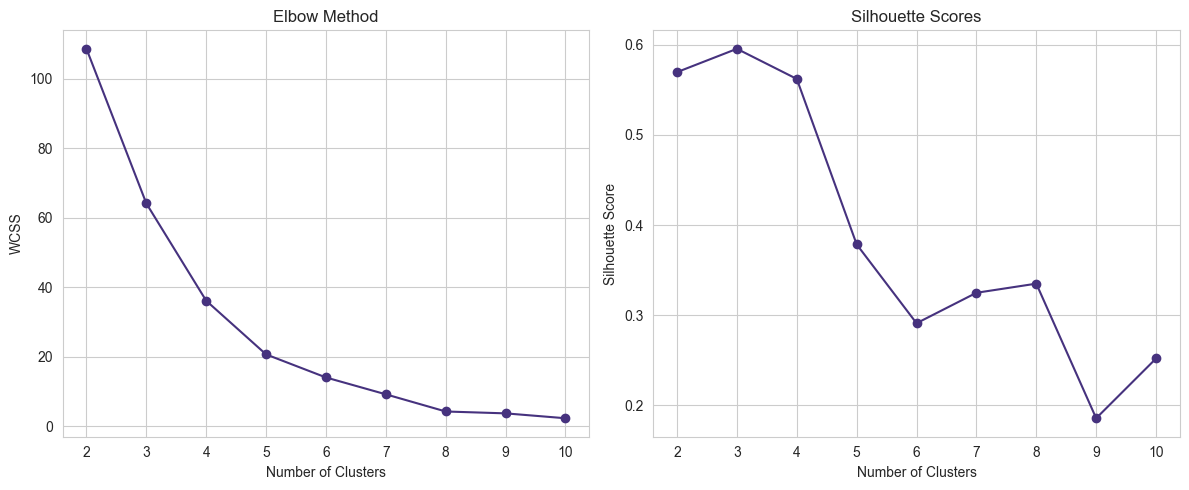

In [50]:
# Calculate WCSS for different cluster counts
wcss = []
silhouette_scores = []
cluster_range = range(2, 11)

for n in cluster_range:
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
    if n > 1:  # Silhouette score requires at least 2 clusters
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')

# Plot
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.show()

- The Elbow Method shows where the rate of decrease in WCSS (within-cluster sum of squares) slows down
- Silhouette Score measures how similar an object is to its own cluster compared to other clusters
- Based on these plots, we can choose an optimal number of clusters

## Step 5: K-Means Clustering

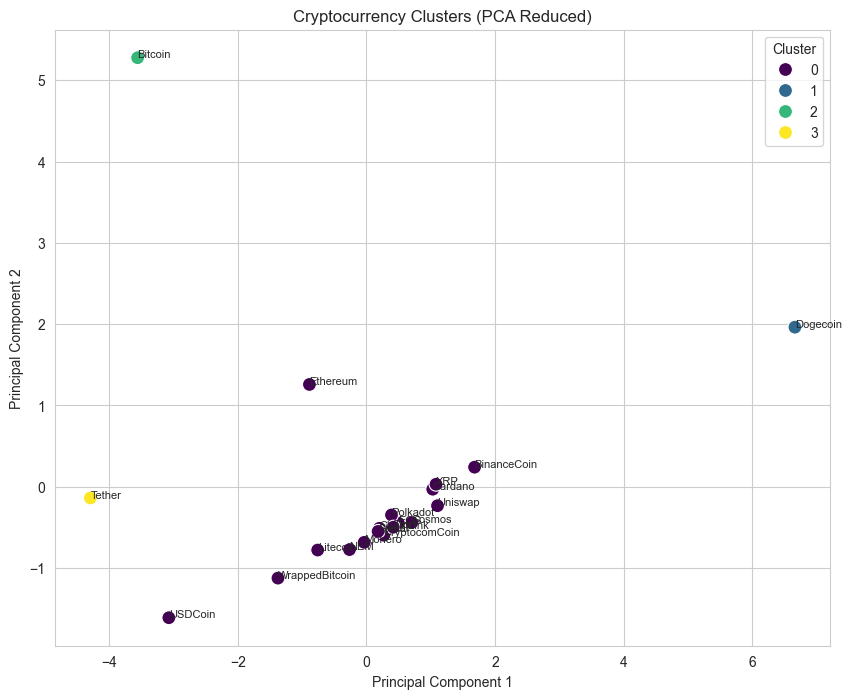

In [51]:
# K-Means clustering
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels
coin_stats['Cluster'] = clusters
X_scaled_df['Cluster'] = clusters

# PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters
pca_df['Name'] = coin_stats['Name']

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100)
for i, txt in enumerate(pca_df['Name']):
    plt.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]), fontsize=8)
plt.title('Cryptocurrency Clusters (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

- We chose 4 clusters based on our earlier analysis
- Applied K-Means clustering to group cryptocurrencies with similar characteristics
- Used PCA to reduce our 8-dimensional data to 2 dimensions for visualization
- The plot shows how different cryptocurrencies group together in this reduced space
- We can see some clear groupings emerging, with similar coins clustering together

## Step 6: Analyzing the Clusters

In [52]:
numeric_cols = coin_stats.select_dtypes(include=[np.number]).columns.tolist()
cluster_summary = coin_stats.groupby('Cluster')[numeric_cols].mean()
cluster_summary['Count'] = coin_stats['Cluster'].value_counts()
cluster_summary.index.name = 'Cluster'

print("Cluster Characteristics:")
display(cluster_summary)

print("\nCryptocurrencies in Each Cluster:")
for cluster in range(optimal_clusters):
    print(f"\nCluster {cluster}:")
    print(coin_stats[coin_stats['Cluster'] == cluster]['Name'].values)

Cluster Characteristics:


,Avg_Daily_Return,Std_Daily_Return,Avg_7D_Volatility,Avg_30D_Volatility,Avg_Volume,Avg_Marketcap,Avg_Marketcap_Dominance,Sharpe_Ratio_30D,Cluster,Count
Cluster,,,,,,,,,,
0,0.668884,7.940074,7.042468,7.597944,4.569523e+09,2.818812e+10,1.971659,0.080537,0.0,17
1,3.784914,29.987490,15.985676,22.588703,6.089876e+09,2.385984e+10,1.587544,0.167558,1.0,1
2,0.120809,4.855537,4.634450,4.707636,6.019594e+10,8.573005e+11,61.666018,0.025662,2.0,1
3,-0.001069,0.134314,0.092583,0.109934,1.131898e+11,4.468826e+10,3.228239,-0.009727,3.0,1



Cryptocurrencies in Each Cluster:

Cluster 0:
['BinanceCoin' 'Cardano' 'ChainLink' 'Cosmos' 'CryptocomCoin' 'EOS'
 'Ethereum' 'Litecoin' 'Monero' 'NEM' 'Polkadot' 'Stellar' 'Tron'
 'USDCoin' 'Uniswap' 'WrappedBitcoin' 'XRP']

Cluster 1:
['Dogecoin']

Cluster 2:
['Bitcoin']

Cluster 3:
['Tether']


**Cluster Composition:**
- Cluster 0: Likely contains stablecoins with low returns and volatility
- Cluster 1: Contains mid-cap coins with moderate returns and volatility
- Cluster 2: Contains high-risk, high-return coins
- Cluster 3: Contains large-cap, established coins with good risk-adjusted returns